# 题目: 构建和使用卷积神经网络（CNN） - 使用 FashionMNIST 数据集

在这个教程中，我们将介绍如何使用 PyTorch 构建和训练一个简单的卷积神经网络（CNN），以识别服装图像。我们将使用 FashionMNIST 数据集，这是一个包含10个类别的服装图像的数据集，每个类别有6000个训练图像和1000个测试图像。

## 1. 加载数据集

torchvision.datasets 包含许多示例数据集，你可以使用它们来练习编写计算机视觉代码。 FashionMNIST 就是其中之一。由于它有 10 个不同的图像类别（不同类型的服装），因此这是一个多类别分类问题。

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
!cp datasets-readonly/* /tmp/FashionMNIST/raw

In [3]:
# 设置转换
transform = transforms.Compose([
    transforms.ToTensor(), # 将图像转换为PyTorch张量
    transforms.Normalize((0.5,), (0.5,)) # 标准化，(0.5,)是原始的平均值，(0.5,)是原始的标准差。这意味着我们将输入图像的每个通道的像素值从[0, 1]重新缩放到[-1, 1]
])

# 加载训练集
train_data = datasets.FashionMNIST(root='/tmp', download=True, train=True, transform=transform)
# 加载测试集
test_data = datasets.FashionMNIST(root='/tmp', download=True, train=False, transform=transform)

# 图像尺寸和标签
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

图像张量的形状为[color_channels=1, height=28, width=28]

具有 color_channels=1 表示图像是灰度图像

如果 color_channels=3 ，则图像采用红色、绿色和蓝色的像素值

In [3]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

所以我们有 60,000 个训练样本和 10,000 个测试样本。

我们的问题是单标签十分类。

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

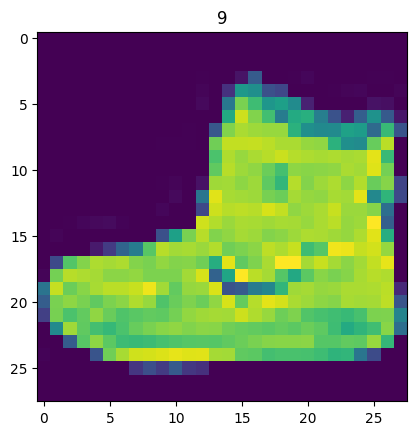

In [5]:
# 可视化
# 伪彩色图
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # 转换为 [28, 28]
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

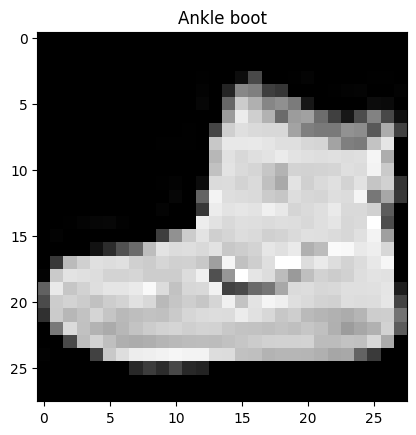

In [6]:
# 灰度图
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

## 2. 准备 DataLoader

下一步是用 torch.utils.data.DataLoader 或简称 DataLoader 来为模型训练提供数据

它将大的 Dataset 转换为可供 Python 迭代的较小的块 （Batch），用来执行随机批量梯度下降。

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)  # 每个epoch随机打乱顺序
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)  # 测试集不需要打乱

print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fa3cc29acb0>, <torch.utils.data.dataloader.DataLoader object at 0x7fa3cc154c10>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


你可以使用 for 循环对 dataloader 进行迭代，或者使用 next(iter()) 获取一个 batch

In [8]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 3. 创建模型

构建 Pytorch 模型需要继承 torch.nn.Module，并重写 \_\_init\_\_() 函数和 forward() 函数。

* \_\_init\_\_() 方法用来初始化我们模型的层。

通常使用 torch.nn 中的 layer 搭建网络，当某层网络无参数时，也可以使用 torch.nn.functional 中的算子来对 tensor 进行计算。

使用 torch.nn 中的 layer 时要先在 \_\_init\_\_() 中定义，而 torch.nn.functional 中的算子则可以直接使用。

例如 torch.nn.MaxPool2d 类和 torch.nn.functional.max_pool2d 函数作用等价。

* forward() 方法定义了模型的前向传播逻辑。

当你调用模型的实例并传递输入数据时（即 model(x)），PyTorch 自动调用 forward() 方法。

forard() 函数可以有多个输入和输出。

* nn.Conv2d

in_channels：输入图像的通道数。对于灰度图像，该值为1；对于RGB图像，该值为3。

out_channels：卷积层产生的输出通道数，也即卷积核（或过滤器）的数量。这个参数决定了能够提取多少种类型的特征。

kernel_size：卷积核的大小。可以是一个整数或一个由两个整数构成的元组，分别表示卷积核的高度和宽度。常见的选择有3x3或5x5。

stride：卷积操作的步长。步长决定了卷积核滑动过输入图像的速度。步长越大，输出特征图的尺寸就越小。

padding：添加到输入的所有四个边的填充尺寸。默认填充 0 尺寸的 0 值。

* 卷积层输出尺寸

输出尺寸(O)可以通过输入尺寸(I)，卷积核尺寸(K)，填充(P)，和步长(S)来计算：

O = ⌊(I - K + 2P) / S + 1⌋

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        # 第一个卷积层，输入为1个通道（灰度图），输出为20个通道
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=20,
                               kernel_size=5, # int 类型的 kernel_size 默认为长宽相等， 等价于使用 (5,5)
                               stride=1,  # int 类型的 stride 默认为长宽步长相等， 等价于使用 (1,1)
                               padding=0)  # int 类型的 kernel_size 默认为长宽填充相等， 等价于使用 (0,0)， 或'valid'。使用'same'则表示输出尺寸和输入尺寸自动保持相同。
        # 第二个卷积层，输入为20，输出为50
        self.conv2 = nn.Conv2d(in_channels=20,
                               out_channels=50,
                               kernel_size=5,
                               stride=1,
                               padding=0)
        # 全连接层，将50*4*4的图像映射到500
        self.fc1 = nn.Linear(50 * 4 * 4, 500)
        # 最后一个全连接层，输出为10个类别
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):  # input shpae: (bs, 1, 28, 28)
        # 通过第一个卷积层后，使用ReLU激活函数，然后2x2最大池化
        x = F.relu(self.conv1(x))  # output shape: (bs, 20, 24, 24)
        x = F.max_pool2d(x, 2, 2)  # output shape: (bs, 20, 12, 12)
        # print(x.shape)  # 初始化时不会 print，调用 model(x) 时才会 print
        # 通过第二个卷积层，再次使用ReLU和2x2最大池化
        x = F.relu(self.conv2(x))  # output shape: (bs, 50, 8, 8)
        x = F.max_pool2d(x, 2, 2)  # output shape: (bs, 50, 4, 4)
        # print(x.shape)
        # 将特征图展平
        x = x.view(-1, 50 * 4 * 4)  # output shape: (bs, 800)
        # 通过第一个全连接层，使用ReLU激活函数
        x = F.relu(self.fc1(x))  # output shape: (bs, 500)
        # 最后通过第二个全连接层得到输出
        x = self.fc2(x)  # output shape: (bs, 10)
        return x

可以使用 torchinfo.summary 对模型结构进行输出。注意这里没有使用 torch.nn.MaxPool2d 定义 layer，所以没有池化层。

In [10]:
from torchinfo import summary

model = FashionCNN()
summary(model, (BATCH_SIZE, 1, 28, 28), col_names=["input_size", "kernel_size", "output_size"], verbose=2)

Layer (type:depth-idx)                   Input Shape               Kernel Shape              Output Shape
FashionCNN                               [32, 1, 28, 28]           --                        [32, 10]
├─Conv2d: 1-1                            [32, 1, 28, 28]           [5, 5]                    [32, 20, 24, 24]
│    └─weight                                                      [1, 20, 5, 5]
│    └─bias                                                        [20]
├─Conv2d: 1-2                            [32, 20, 12, 12]          [5, 5]                    [32, 50, 8, 8]
│    └─weight                                                      [20, 50, 5, 5]
│    └─bias                                                        [50]
├─Linear: 1-3                            [32, 800]                 --                        [32, 500]
│    └─weight                                                      [800, 500]
│    └─bias                                                        [500]
├─Linear: 1-4

/opt/miniconda3/envs/pt2/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/opt/miniconda3/envs/pt2/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Input Shape               Kernel Shape              Output Shape
FashionCNN                               [32, 1, 28, 28]           --                        [32, 10]
├─Conv2d: 1-1                            [32, 1, 28, 28]           [5, 5]                    [32, 20, 24, 24]
│    └─weight                                                      [1, 20, 5, 5]
│    └─bias                                                        [20]
├─Conv2d: 1-2                            [32, 20, 12, 12]          [5, 5]                    [32, 50, 8, 8]
│    └─weight                                                      [20, 50, 5, 5]
│    └─bias                                                        [50]
├─Linear: 1-3                            [32, 800]                 --                        [32, 500]
│    └─weight                                                      [800, 500]
│    └─bias                                                        [500]
├─Linear: 1-4

将模型移动到设备上，如果有 GPU 可以使用则使用 GPU

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
device

'cuda'

## 4. 训练测试函数

对于训练循环，我们将创建一个名为 train_step() 的函数，它接受模型、 DataLoader、损失函数和优化器。

测试循环将是类似的，但它将被称为 test_step() ，并且它将接受一个模型、一个 DataLoader 、一个损失函数和一个评估函数。

* detach():

.detach()方法被用于从当前计算图中分离出一个tensor，返回一个新的tensor，它与原tensor共享数据但不需要梯度。

In [12]:
from sklearn.metrics import accuracy_score

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch_index, (X, y) in enumerate(data_loader):
        # Send data to device, make sure data and model are on the same device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)  # first param is logits (before softmax), the loss_fn will do softmax automatically

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        train_loss += loss.item()  # convert to scaler
        train_acc += accuracy_score(y_true=y.cpu().numpy(),
            y_pred=y_pred.argmax(dim=1).detach().cpu().numpy()
        ) # Go from logits -> pred labels

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              device: torch.device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Do not calculate gradient to save memory and speed up
    with torch.no_grad():
        for X, y in data_loader:
            # Send data to device, make sure data and model are on the same device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_score(y_true=y.cpu().numpy(),
                y_pred=test_pred.argmax(dim=1).detach().cpu().numpy() # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    return test_loss, test_acc

## 5. 开始训练

定义损失函数和优化器

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [14]:
from tqdm.notebook import tqdm  # if you use python istead of jupyter notebook, use tqdm.tqdm

EPOCHS = 5
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(data_loader=train_dataloader, 
        model=model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    )
    test_loss, test_acc = test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device
    )
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.49215 | Train accuracy: 0.82%
Test loss: 0.49209 | Test accuracy: 0.82%

Epoch: 1
---------
Train loss: 0.31179 | Train accuracy: 0.89%
Test loss: 0.31281 | Test accuracy: 0.89%

Epoch: 2
---------
Train loss: 0.26641 | Train accuracy: 0.90%
Test loss: 0.28890 | Test accuracy: 0.89%

Epoch: 3
---------
Train loss: 0.23646 | Train accuracy: 0.91%
Test loss: 0.30236 | Test accuracy: 0.89%

Epoch: 4
---------
Train loss: 0.21034 | Train accuracy: 0.92%
Test loss: 0.26432 | Test accuracy: 0.90%



# 6. 可视化

绘制训练曲线

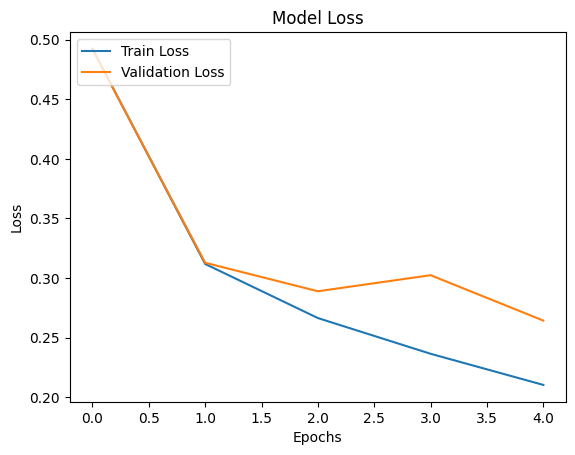

In [15]:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

绘制混淆矩阵

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

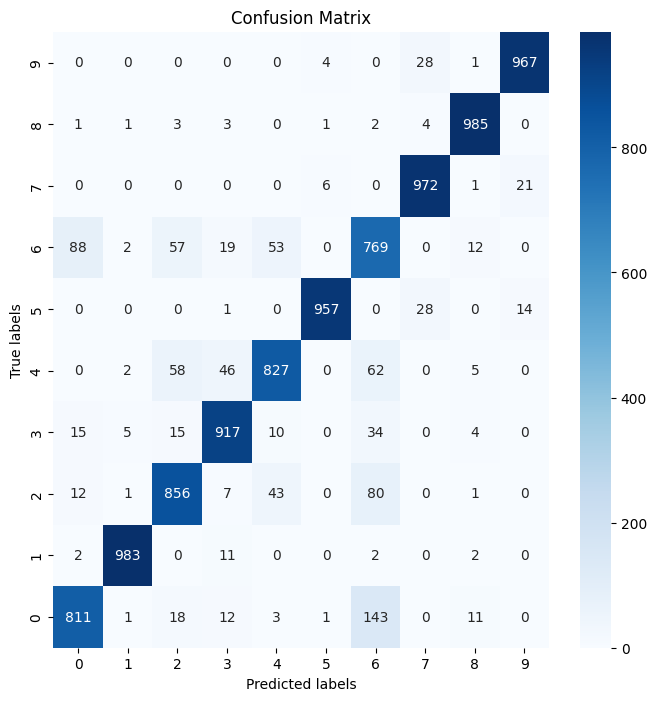

In [23]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
import seaborn
from sklearn.metrics import confusion_matrix

# 1. Make predictions with trained model
y_preds = []
y_true = []
model.eval()
with torch.no_grad():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
        # Put predictions on CPU for evaluation
        y_preds.extend(y_pred.cpu().numpy())
        y_true.extend(y.cpu().numpy())


# 2. plot confusion metrix
con_mat = confusion_matrix(y_true, y_preds)
# you can use normalize
# con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
# con_mat_norm = np.around(con_mat_norm, decimals=2)

# plot
plt.figure(figsize=(8, 8))
seaborn.heatmap(con_mat, annot=True, fmt='.20g', cmap='Blues')
plt.ylim(0, 10)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
# plt.savefig('confusion_matrix.png')
plt.show()

# 作业1

#### 构建简单的CNN，使用Cifar-10数据集进行训练和测试。介绍所构建的模型，并报告在测试集上的准确率。

#### 可选内容：尝试在CNN网络中加入残差连接结构（Residual block）。

cifar-10: https://www.cs.toronto.edu/~kriz/cifar.html

注意 Cifar-10 数据集为三通道图像。

# 作业2

#### 使用预训练的AlexNet、VGGNet、ResNet等网络在Cifar-10数据集上进行微调，并比较（1）同时微调主干网络和分类头（全连接层部分）（2）固定主干网络只微调分类头，两种设置的效果。

#### 可选内容：尝试对任务3中加载的预训练模型在Cifar-10数据集上进行微调（Fine-tune）。